In [1]:
from datetime import datetime
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def parse_str(x):
    """
    Returns the string delimited by two characters.

    Example:
        `>>> parse_str('[my string]')`
        `'my string'`
    """
    return x[1:-1]

def parse_datetime(x):
    '''
    Parses datetime with timezone formatted as:
        `[day/month/year:hour:minute:second zone]`

    Example:
        `>>> parse_datetime('13/Nov/2015:11:45:42 +0000')`
        `datetime.datetime(2015, 11, 3, 11, 45, 4, tzinfo=<UTC>)`

    Due to problems parsing the timezone (`%z`) with `datetime.strptime`, the
    timezone will be obtained using the `pytz` library.
    '''
    dt = datetime.strptime(x[1:-7], '%d/%b/%Y:%H:%M:%S')
    dt_tz = int(x[-6:-3])*60+int(x[-3:-1])
    return dt.replace(tzinfo=pytz.FixedOffset(dt_tz))

In [2]:
# Separators:

#   \s                           # Match space.
#   (?=(?:[^"]*"[^"]*")*[^"]*$)  # Not surrounded by ".
#   (?![^\[]*\])                 # Not surrounded by [].

In [3]:
import re

raw_data = pd.read_csv(
    'Web_access_log-akumenius.com.txt',
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
    engine='python',
    na_values='-',
    header=None,
    usecols=[1, 4, 5, 6, 7, 8, 9],
    names=['ip', 'date', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'date': parse_datetime,
               'request': parse_str,
               'status': int,
               'size': int,
               'referer': parse_str})

In [4]:
raw_data.tail(5)

,ip,date,request,status,size,referer,user_agent
261868,5.255.253.53,2014-03-02 03:05:39+01:00,GET / HTTP/1.1,200,7528,NaN,"""Mozilla/5.0 (compatible; YandexBot/3.0; +http..."
261869,74.86.158.107,2014-03-02 03:09:52+01:00,HEAD / HTTP/1.1,200,NaN,NaN,"""Mozilla/5.0+(compatible; UptimeRobot/2.0; htt..."
261870,127.0.0.1,2014-03-02 03:10:18+01:00,OPTIONS * HTTP/1.0,200,NaN,NaN,"""Apache (internal dummy connection)"""
261871,127.0.0.1,2014-03-02 03:10:18+01:00,OPTIONS * HTTP/1.0,200,NaN,NaN,"""Apache (internal dummy connection)"""
261872,127.0.0.1,2014-03-02 03:10:18+01:00,OPTIONS * HTTP/1.0,200,NaN,NaN,"""Apache (internal dummy connection)"""


### NA's:

In [5]:
round(raw_data.isna().sum()/len(raw_data), 2)

ip            0.00
date          0.00
request       0.00
status        0.00
size          0.16
referer       0.38
user_agent    0.00
dtype: float64

### Visualizing Not Na's

In [6]:
raw_data_referer_notnull = raw_data[raw_data['referer'].notnull()]
raw_data_referer_notnull.head(3)

,ip,date,request,status,size,referer,user_agent
357,199.30.20.223,2014-02-23 03:18:51+01:00,GET /includes/css/style.css HTTP/1.1,200,3637,http://www.akumenius.com/hoteles-baratos/ofert...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK..."
358,199.30.20.223,2014-02-23 03:18:51+01:00,GET /modules/raton/views/themes/bcoos/css/butt...,200,48,http://www.akumenius.com/hoteles-baratos/ofert...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK..."
359,199.30.20.223,2014-02-23 03:18:51+01:00,GET /modules/raton/views/themes/bcoos/css/2col...,200,15439,http://www.akumenius.com/hoteles-baratos/ofert...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK..."


In [7]:
raw_data['user_agent'].loc[261819]

'"Mozilla/5.0 (iPhone; CPU iPhone OS 6_0 like Mac OS X) AppleWebKit/536.26 (KHTML, like Gecko) Version/6.0 Mobile/10A5376e Safari/8536.25 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"'

### hour and weekday columns

In [8]:
raw_data['time'] = raw_data['date'].dt.time

In [9]:
raw_data['hour'] = raw_data['time'].astype('str').str[0:2].astype('int')

In [10]:
raw_data['weekday'] = raw_data['date'].dt.weekday_name
raw_data['weekday'] = pd.Categorical(raw_data['weekday'], categories = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], ordered = True)

### Country column throguh GeoLocation

In [11]:
from geolite2 import geolite2

def get_country(ip):
    try:
        x = geo.get(ip)
    except ValueError:
        return pd.np.nan
    try:
        return x['country']['names']['en'] if x else pd.np.nan
    except KeyError:
        return pd.np.nan

geo = geolite2.reader()

In [12]:
# get unique IPs
unique_ips = raw_data['ip'].unique()
# make series out of it
unique_ips = pd.Series(unique_ips, index = unique_ips)
# map IP --> country
raw_data['country'] = raw_data['ip'].map(unique_ips.apply(get_country))

geolite2.close()

### Agent User: Device, OS, Browser.

In [13]:
from user_agents import parse
from ua_parser import user_agent_parser
import pprint

In [14]:
user_agent = raw_data[['user_agent']]
user_agent.head()

,user_agent
0,"""Apache (internal dummy connection)"""
1,"""Apache (internal dummy connection)"""
2,"""Apache (internal dummy connection)"""
3,"""Apache (internal dummy connection)"""
4,"""Apache (internal dummy connection)"""


In [15]:
raw_data['parsed_user_agent'] = raw_data['user_agent'].apply(parse)

In [16]:
raw_data.tail(10)

,ip,date,request,status,size,referer,user_agent,time,hour,weekday,country,parsed_user_agent
261863,5.255.253.53,2014-03-02 03:05:32+01:00,GET /robots.txt HTTP/1.1,301,301,NaN,"""Mozilla/5.0 (compatible; YandexBot/3.0; +http...",03:05:32,3,Sunday,Russia,Spider / Other / YandexBot 3.0
261864,5.255.253.53,2014-03-02 03:05:33+01:00,GET /robots.txt HTTP/1.1,301,304,NaN,"""Mozilla/5.0 (compatible; YandexBot/3.0; +http...",03:05:33,3,Sunday,Russia,Spider / Other / YandexBot 3.0
261865,5.255.253.53,2014-03-02 03:05:35+01:00,GET / HTTP/1.1,301,301,NaN,"""Mozilla/5.0 (compatible; YandexBot/3.0; +http...",03:05:35,3,Sunday,Russia,Spider / Other / YandexBot 3.0
261866,5.255.253.53,2014-03-02 03:05:34+01:00,GET / HTTP/1.1,200,7528,NaN,"""Mozilla/5.0 (compatible; YandexBot/3.0; +http...",03:05:34,3,Sunday,Russia,Spider / Other / YandexBot 3.0
261867,5.255.253.53,2014-03-02 03:05:35+01:00,GET / HTTP/1.1,301,304,NaN,"""Mozilla/5.0 (compatible; YandexBot/3.0; +http...",03:05:35,3,Sunday,Russia,Spider / Other / YandexBot 3.0
261868,5.255.253.53,2014-03-02 03:05:39+01:00,GET / HTTP/1.1,200,7528,NaN,"""Mozilla/5.0 (compatible; YandexBot/3.0; +http...",03:05:39,3,Sunday,Russia,Spider / Other / YandexBot 3.0
261869,74.86.158.107,2014-03-02 03:09:52+01:00,HEAD / HTTP/1.1,200,NaN,NaN,"""Mozilla/5.0+(compatible; UptimeRobot/2.0; htt...",03:09:52,3,Sunday,United States,Spider / Other / UptimeRobot 2.0
261870,127.0.0.1,2014-03-02 03:10:18+01:00,OPTIONS * HTTP/1.0,200,NaN,NaN,"""Apache (internal dummy connection)""",03:10:18,3,Sunday,NaN,Other / Other / Other
261871,127.0.0.1,2014-03-02 03:10:18+01:00,OPTIONS * HTTP/1.0,200,NaN,NaN,"""Apache (internal dummy connection)""",03:10:18,3,Sunday,NaN,Other / Other / Other
261872,127.0.0.1,2014-03-02 03:10:18+01:00,OPTIONS * HTTP/1.0,200,NaN,NaN,"""Apache (internal dummy connection)""",03:10:18,3,Sunday,NaN,Other / Other / Other


In [17]:
raw_data[['device', 'OS', 'browser', 'ua_4']] = raw_data['parsed_user_agent'].apply(lambda x: pd.Series(str(x).split('/'))) 

In [18]:
raw_data = raw_data.drop('ua_4', axis=1)

In [19]:
raw_data.tail(4)

,ip,date,request,status,size,referer,user_agent,time,hour,weekday,country,parsed_user_agent,device,OS,browser
261869,74.86.158.107,2014-03-02 03:09:52+01:00,HEAD / HTTP/1.1,200,NaN,NaN,"""Mozilla/5.0+(compatible; UptimeRobot/2.0; htt...",03:09:52,3,Sunday,United States,Spider / Other / UptimeRobot 2.0,Spider,Other,UptimeRobot 2.0
261870,127.0.0.1,2014-03-02 03:10:18+01:00,OPTIONS * HTTP/1.0,200,NaN,NaN,"""Apache (internal dummy connection)""",03:10:18,3,Sunday,NaN,Other / Other / Other,Other,Other,Other
261871,127.0.0.1,2014-03-02 03:10:18+01:00,OPTIONS * HTTP/1.0,200,NaN,NaN,"""Apache (internal dummy connection)""",03:10:18,3,Sunday,NaN,Other / Other / Other,Other,Other,Other
261872,127.0.0.1,2014-03-02 03:10:18+01:00,OPTIONS * HTTP/1.0,200,NaN,NaN,"""Apache (internal dummy connection)""",03:10:18,3,Sunday,NaN,Other / Other / Other,Other,Other,Other


In [20]:
print('cantidad de valores diferentes device: ',len(raw_data.device.unique()))
print('cantidad de valores diferentes OS: ',len(raw_data.OS.unique()))
print('cantidad de valores diferentes browser: ',len(raw_data.browser.unique()))

raw_data.OS.unique()

cantidad de valores diferentes device:  168
cantidad de valores diferentes OS:  87
cantidad de valores diferentes browser:  224


array([' Other ', ' Linux ', ' Windows 7 ', ' iOS 6.0 ', ' Windows 95 ',
       ' Windows Vista ', ' Windows XP ', ' Mac OS X 10.5.8 ',
       ' iOS 4.3.2 ', ' Android 4.3 ', ' iOS 7.0.4 ', ' Windows 2000 ',
       ' Android 2.3.7 ', ' Windows NT ', ' Android 4.1.2 ',
       ' Android 4.1.1 ', ' iOS 7.0.2 ', ' iOS 5.0.1 ', ' Android 2.3.5 ',
       ' iOS 6.1.3 ', ' Windows 8.1 ', 'S5570BVKT1 ', ' iOS 7.0.6 ',
       ' iOS 7.0.5 ', ' Android 4.2.1 ', ' Android 4.0.4 ',
       ' BlackBerry OS 6.0.0 ', ' Windows 8 ', ' iOS 3.2 ', ' iOS 6.1 ',
       ' iOS 7.0 ', ' Android 4.0.3 ', ' Android 2.3.4 ', ' iOS 5.1.1 ',
       ' Android 4.2.2 ', ' Ubuntu ', ' Android 2.3.6 ', ' iOS 7.0.3 ',
       ' Mac OS X 10.9.1 ', ' Android 4.3.1 ', ' Android ',
       ' Mac OS X 10.8.4 ', 'I9001BVKPA ', ' Mac OS X 10.8.5 ',
       'I9300BVALF4 ', ' iOS 6.0.1 ', ' Fedora 3.6.17 ',
       ' Fedora 3.1.10 ', ' Android 2.2.2 ', 'I9100BVKH1 ',
       ' Windows ME ', ' Android 4.0.9 ', ' iOS 6.1.6 ', ' Android 2

In [117]:
raw_data['cleaned_OS'] = raw_data['OS'].str.extract('([A-Za-z]+)')
raw_data[raw_data['OS'] != (' Other ')]

KeyError: 'OS'

In [22]:
raw_data['cleaned_OS'].value_counts()

Other         96193
Windows       92602
Android       28684
iOS           20865
Fedora        13927
Mac            4141
Linux          2799
Ubuntu         1360
BlackBerry      587
I               527
S               187
Red               1
Name: cleaned_OS, dtype: int64

In [23]:
raw_data.isna().sum()

ip                       0
date                     0
request                 37
status                   0
size                 42335
referer              99547
user_agent               0
time                     0
hour                     0
weekday                  0
country              15111
parsed_user_agent        0
device                   0
OS                       0
browser                  0
cleaned_OS               0
dtype: int64

### Replace "Red" by "Red Hat", "I" by "I models", "S" by "S" models

In [24]:
raw_data.loc[raw_data['cleaned_OS'] == 'Red', 'cleaned_OS'] = 'Red Hat'
raw_data.loc[raw_data['cleaned_OS'] == 'I', 'cleaned_OS'] = 'I Series'
raw_data.loc[raw_data['cleaned_OS'] == 'S', 'cleaned_OS'] = 'S Series'

In [25]:
raw_data['cleaned_OS'].value_counts()

Other         96193
Windows       92602
Android       28684
iOS           20865
Fedora        13927
Mac            4141
Linux          2799
Ubuntu         1360
BlackBerry      587
I Series        527
S Series        187
Red Hat           1
Name: cleaned_OS, dtype: int64

### Final status column

In [26]:
raw_data.status = raw_data.status.astype('int')

In [27]:
raw_data.dtypes

ip                                                 object
date                 datetime64[ns, pytz.FixedOffset(60)]
request                                            object
status                                              int32
size                                               object
referer                                            object
user_agent                                         object
time                                               object
hour                                                int32
weekday                                          category
country                                            object
parsed_user_agent                                  object
device                                             object
OS                                                 object
browser                                            object
cleaned_OS                                         object
dtype: object

In [28]:
status_conditions = [(raw_data['status']>=200) & (raw_data['status']<300),
              (raw_data['status']>=300) & (raw_data['status']<400),
              (raw_data['status']>=400) & (raw_data['status']<500),
              (raw_data['status']>=500)]

In [29]:
status_values = [
    '200+: succesful',
    '300+: redirected', 
    '400+: client error',
    '500+: server error'
]

In [30]:
raw_data['final_status'] = np.select(status_conditions, status_values)

### Data columns reorder

In [31]:
columns = ['ip', 'country', 'request', 'final_status', 'size', 'referer', 'device', 'cleaned_OS', 'browser', 'date', 'time', 'hour', 'weekday']

In [32]:
raw_data = raw_data[columns]

# Analysis for external visits

### Removing bots and local host

In [118]:
data = raw_data[(raw_data['ip'] != '127.0.0.1') & (~raw_data.browser.str.contains('bot', flags=re.IGNORECASE, regex=True))]
data.head()

,ip,country,request,status,final_status,size,referer,parsed_user_agent,device,cleaned_OS,browser,date,time,hour,weekday
44,193.111.141.116,Germany,GET /hoteles-baratos/ofertas-hotel-Roque-Monic...,404,400+: client error,17750,NaN,PC / Linux / Firefox 6.0,PC,Linux,Firefox 6.0,2014-02-23 03:11:07+01:00,03:11:07,3,Sunday
69,180.76.5.223,China,GET /destinos-baratos/hoteles-en-TlaxcalaMEXIC...,200,200+: succesful,7630,NaN,Spider / Other / Baiduspider 2.0,Spider,Other,Baiduspider 2.0,2014-02-23 03:11:45+01:00,03:11:45,3,Sunday
72,180.76.6.148,China,GET /destinos-baratos/destinos-caracteristicas...,200,200+: succesful,8280,NaN,Spider / Other / Baiduspider 2.0,Spider,Other,Baiduspider 2.0,2014-02-23 03:12:00+01:00,03:12:00,3,Sunday
73,180.76.5.188,China,GET /destinos-baratos/destinos-caracteristicas...,200,200+: succesful,7201,NaN,Spider / Other / Baiduspider 2.0,Spider,Other,Baiduspider 2.0,2014-02-23 03:12:08+01:00,03:12:08,3,Sunday
74,180.76.6.135,China,GET /destinos-baratos/hoteles-baratos/ofertas-...,404,400+: client error,3100,NaN,Spider / Other / Baiduspider 2.0,Spider,Other,Baiduspider 2.0,2014-02-23 03:12:16+01:00,03:12:16,3,Sunday


### Range of time tracked

In [34]:
print('La primera fecha trackeada fue: ', raw_data['time'].sort_values(ascending=False).loc[0])
print('La última fecha trackeada fue: ', raw_data['time'].sort_values(ascending=False).loc[261872])

La primera fecha trackeada fue:  03:10:31
La última fecha trackeada fue:  03:10:18


### Visits by Time

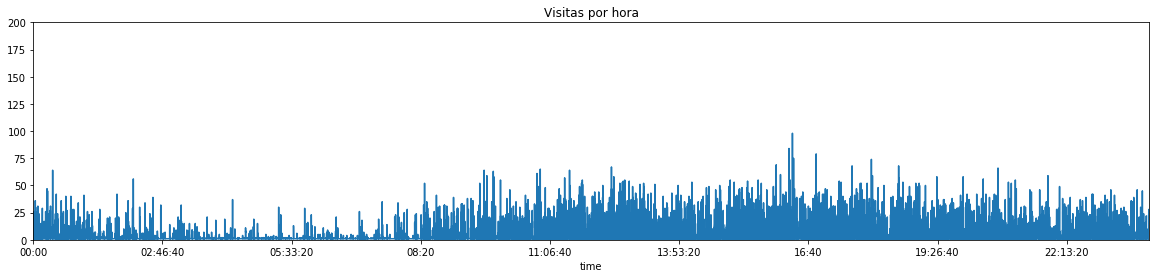

In [35]:
#data.groupby('hour')['ip'].count().plot()

fig = plt.figure(figsize=(20,4))
ax = fig.gca()
data.groupby('time')['ip'].count().plot(title='Visitas por hora', ax=ax)
ax.set_ylim(0,200)
plt.show()

### Visits by Hour

First hours in the morning show the lowest volume of visits while hours from 11 to 20 hs accumulate most of the visits

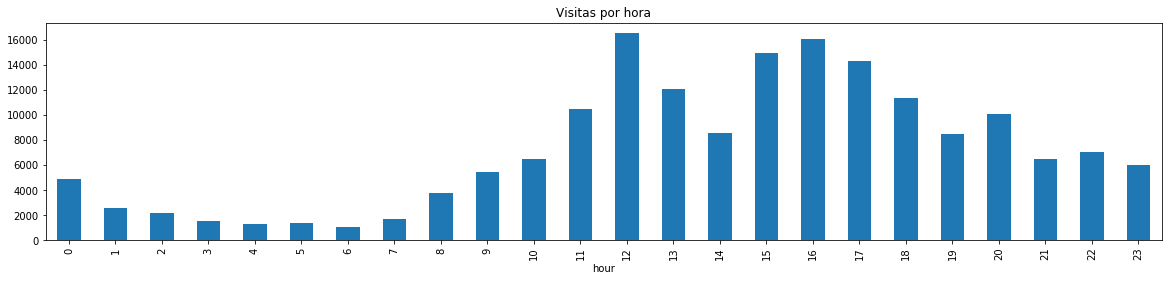

In [36]:
#data.groupby('hour')['ip'].count().plot()

fig2 = plt.figure(figsize=(20,4))
ax2 = fig2.gca()
data.groupby('hour')['ip'].count().plot(kind='bar', title='Visitas por hora', ax=ax2)
ax2.set_ylim()
plt.show()

### Most commons IP visitors

In [37]:
data['ip'].value_counts().head(5)

80.28.221.123     14725
217.125.71.222     5201
62.117.197.230     2567
89.128.176.162     1093
176.31.255.177     1044
Name: ip, dtype: int64

### Visits by Weekday

Visits 

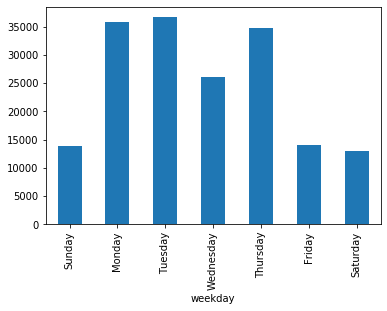

In [38]:
data.groupby('weekday')['ip'].count().plot(kind='bar')

### Visits by weekday and hour (7 graphs)

C:\Users\tomi_\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


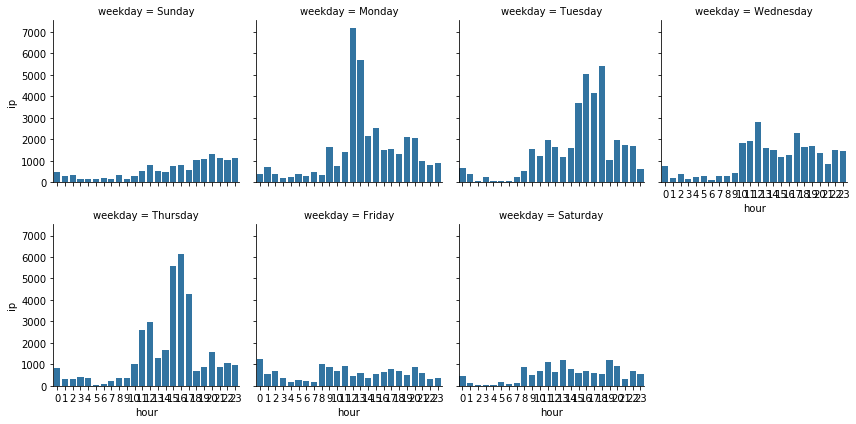

In [39]:
weekday_graph = sns.FacetGrid(data=data.groupby(['weekday', 'hour'])['ip'].count().reset_index(), col='weekday', col_order=[
    'Sunday',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday'
], col_wrap=4)
weekday_graph.map(sns.barplot, 'hour', 'ip');

### Visits by STATUS

In [40]:
status_pct = round(data.final_status.value_counts()/len(data), 2)
status_pct

200+: succesful       0.84
300+: redirected      0.15
400+: client error    0.01
500+: server error    0.00
Name: final_status, dtype: float64

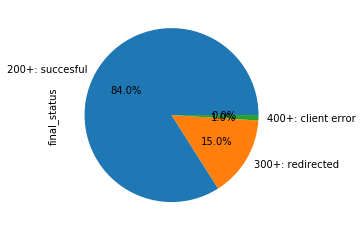

In [41]:
status_pct.plot(kind='pie', autopct="%.1f%%")

### Visits + hour, weekday and STATUS

In [42]:
stacked = data.groupby(['weekday', 'final_status', 'hour'])[['ip']].count().reset_index()
stacked = stacked.rename(columns = {'ip': 'visits'})
stacked.head()

,weekday,final_status,hour,visits
0,Sunday,200+: succesful,0,439.0
1,Sunday,200+: succesful,1,263.0
2,Sunday,200+: succesful,2,306.0
3,Sunday,200+: succesful,3,124.0
4,Sunday,200+: succesful,4,139.0


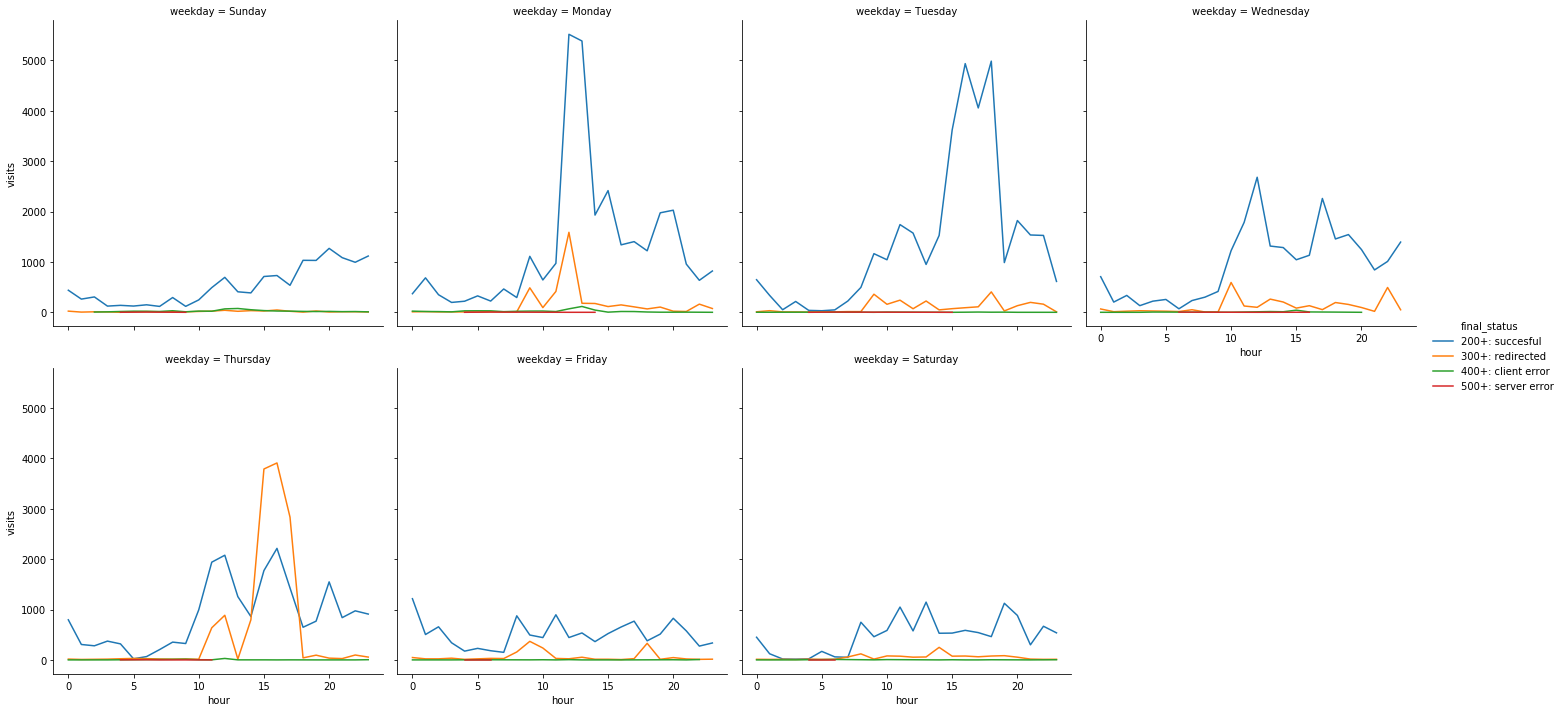

In [43]:
sns.relplot(x='hour', y='visits', data=stacked,
            kind='line', hue='final_status', col='weekday', col_wrap=4, col_order=[
    'Sunday',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday'
])

### Is there a pattern in client error connections? status = 400+

CLIENT ERROR CONNECTIONS OCCURRED MAINLY DURING SUNDAY AND MONDAY, THE MAIN 2 DAYS TRACKED.

In [122]:
client_error_visists = data[data['final_status'] == '400+: client error']

In [123]:
client_error = client_error_visists.groupby(['weekday', 'final_status', 'hour'])[['ip']].count().reset_index()
client_error = client_error.rename(columns = {'ip': 'visits'})

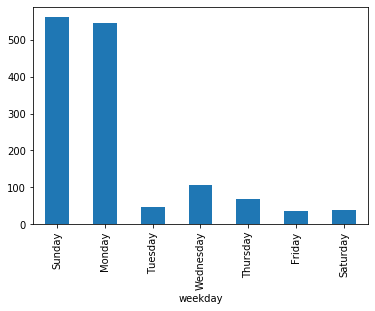

In [124]:
data[data['final_status'] == '400+: client error'].groupby(['weekday'])['ip'].count().plot(kind='bar')

<span style=color:red><ins>**Most error connections from Spider devices**</ins></span>

In [127]:
client_error_visists.device.value_counts().head(4)

Spider     946
PC         263
Other      150
iPad        26
Name: device, dtype: int64

In [130]:
client_error_visists.cleaned_OS.value_counts()

Other         1093
Fedora         152
Windows         72
Linux           37
iOS             27
Android         16
Mac              3
Ubuntu           2
I Series         2
BlackBerry       1
Name: cleaned_OS, dtype: int64

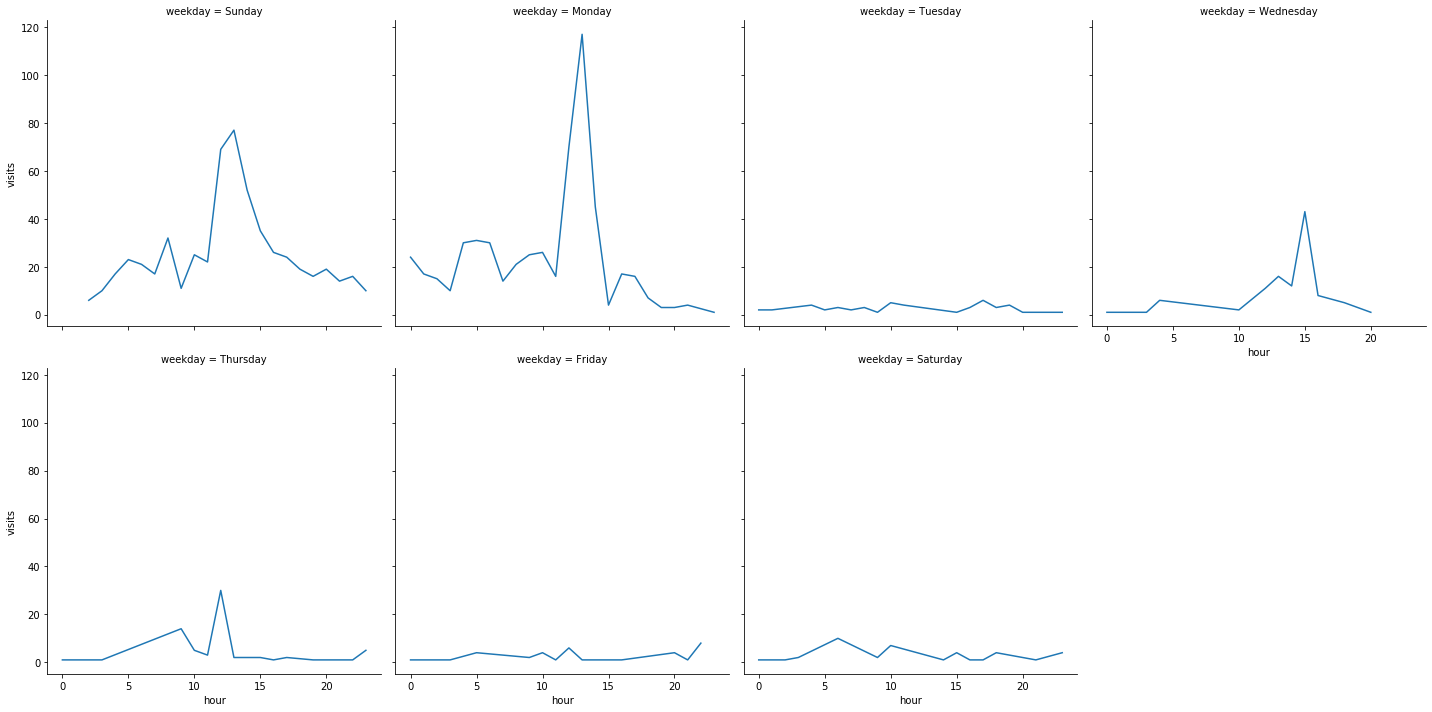

In [45]:
sns.relplot(data=client_error, x='hour', y='visits', col='weekday', col_wrap=4, kind='line', col_order=[
    'Sunday',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday'
])

### Top IP countries

In [47]:
visits_by_country = data.groupby('country')[['ip']].count().sort_values(by='ip', ascending=False)
top5_countries = visits_by_country.iloc[:5,:]
other_countries = pd.DataFrame(data= {'ip': [visits_by_country[5:].sum()]})
visits_with_other = pd.concat([top5_countries, other_countries])
visits_with_other

,ip
Spain,149174
China,7010
United States,4671
France,1751
Mexico,1244
0,ip 9168 dtype: int64


# BOT's visits

In [65]:
# Bot filtering:

only_bots = raw_data[(raw_data.browser.str.contains('bot', 
             flags=re.IGNORECASE, regex=True))]

In [66]:
only_bots.head()

,ip,country,request,status,final_status,size,referer,parsed_user_agent,device,cleaned_OS,browser,date,time,hour,weekday
22,66.249.76.216,United States,GET /hoteles-baratos/ofertas-hotel-Club-&-Hote...,404,400+: client error,3100,NaN,Spider / Other / Googlebot 2.1,Spider,Other,Googlebot 2.1,2014-02-23 03:10:31+01:00,03:10:31,3,Sunday
23,66.249.76.216,United States,GET /hoteles-baratos/ofertas-hotel-Metropolis-...,404,400+: client error,3100,NaN,Spider / Other / Googlebot 2.1,Spider,Other,Googlebot 2.1,2014-02-23 03:10:33+01:00,03:10:33,3,Sunday
24,66.249.76.216,United States,GET /hoteles-baratos/ofertas-hotel-Faena-Hotel...,404,400+: client error,3100,NaN,Spider / Other / Googlebot 2.1,Spider,Other,Googlebot 2.1,2014-02-23 03:10:35+01:00,03:10:35,3,Sunday
25,66.249.76.216,United States,GET /hoteles-baratos/ofertas-hotel-Kensington-...,404,400+: client error,3100,NaN,Spider / Other / Googlebot 2.1,Spider,Other,Googlebot 2.1,2014-02-23 03:10:38+01:00,03:10:38,3,Sunday
26,66.249.76.216,United States,GET /destinos-baratos/destinosEstrelles/hotele...,200,200+: succesful,8811,NaN,Spider / Other / Googlebot 2.1,Spider,Other,Googlebot 2.1,2014-02-23 03:10:39+01:00,03:10:39,3,Sunday


<span style=color:red><ins>**BOTS VS REGULAR VISITS**</ins></span>

In [68]:
print(round(len(only_bots)/len(raw_data), 2), '% of total visits are BOTS')

0.28 % of total visits are BOTS


<span style=color:red><ins>**MOST BOTS COMING FROM USA**</ins></span>

In [69]:
countries = only_bots.groupby('country')['ip'].count().sort_values(ascending=False).reset_index()

In [70]:
countries2 = countries[:3].copy()

In [71]:
countries_new_row = pd.DataFrame(data={'country': ['Other Countries'], 'ip': countries.iloc[3:, 1].sum()})

In [72]:
countries3 = pd.concat([countries2, countries_new_row], axis=0)

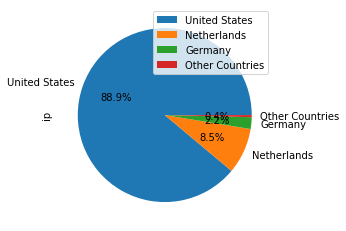

In [73]:
countries3.plot(y='ip', labels=countries3['country'], kind='pie', autopct="%.1f%%")

<span style=color:red><ins>**ALMOST EVERY VISIT COMING FROM USA ARE BOTS**</B></ins></span>

In [74]:
print(round(len(only_bots[only_bots['country'] == 'United States'])/len(raw_data[raw_data['country'] == 'United States']), 2), '% of US visits are bots')

0.93 % of US visits are bots


<span style=color:red><ins>**ONLY 2 DEVICES LISTED FOR BOTS**</B></ins></span>

In [85]:
only_bots.device.value_counts()

Spider     73737
PC             7
Name: device, dtype: int64

<span style=color:red><ins>**90% of Spider devices are Bots**</B></ins></span>

In [110]:
print(round(len(only_bots[only_bots['device']=='Spider '])/len(raw_data[raw_data['device']=='Spider ']), 2), '% of all visits through device Spider are bots')

0.91 % of all visits through device Spider are bots


Text(0, 0.5, 'Visits')

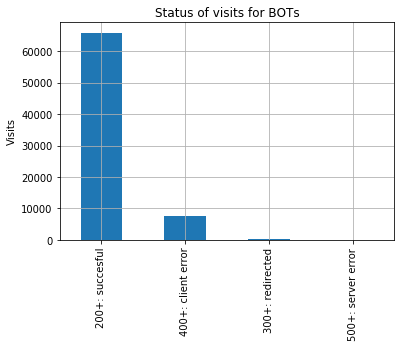

In [115]:
only_bots_status_G = only_bots.final_status.value_counts().plot(kind='bar', title='Status of visits for BOTs', grid=True)
only_bots_status_G.set_ylabel('Visits')

In [89]:
bots_groupped = only_bots.groupby(['weekday', 'hour', 'final_status'])[['ip']].count().reset_index()

In [90]:
bots_groupped = bots_groupped.rename(columns = {'ip': 'visits'})

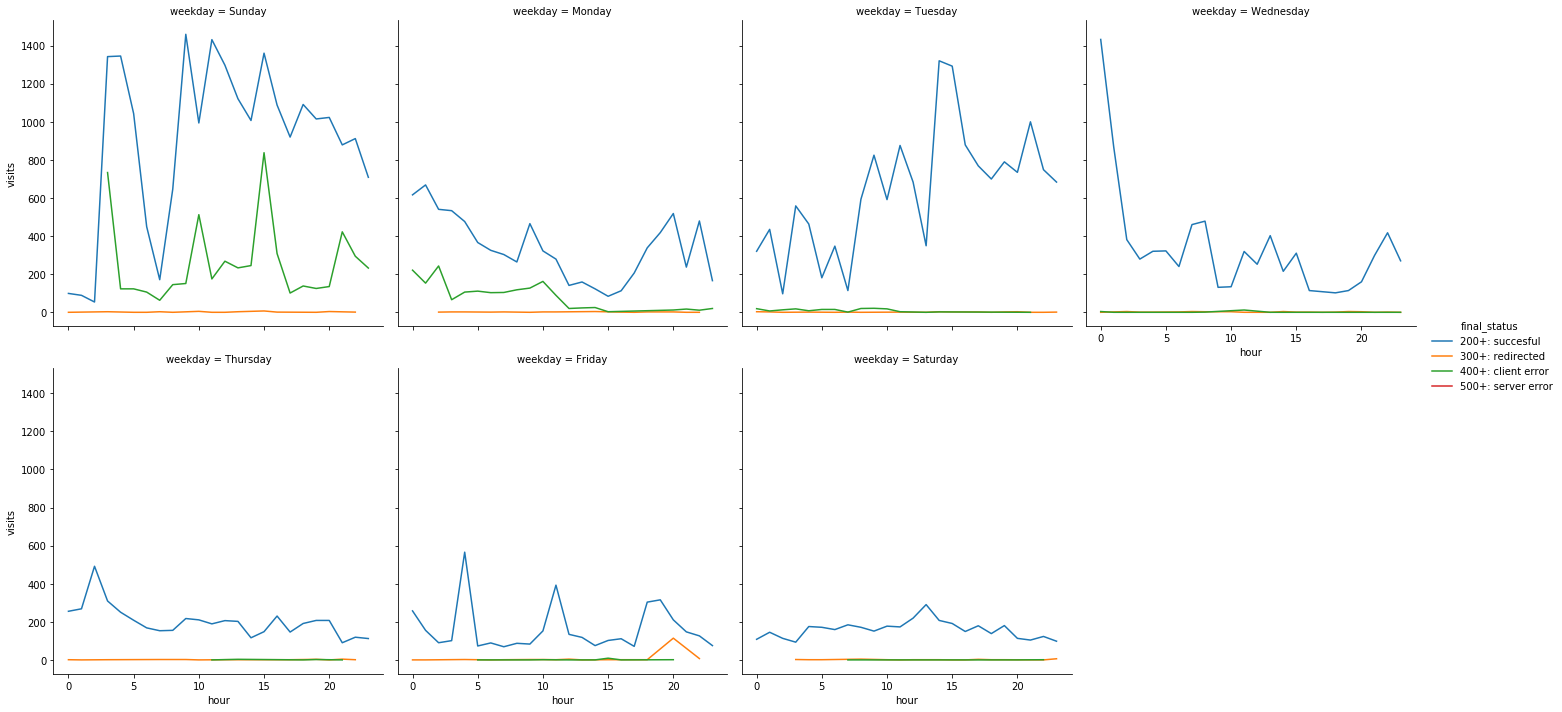

In [91]:
sns.relplot(data=bots_groupped, x='hour', y='visits', col='weekday', hue='final_status', col_wrap=4, kind='line', col_order=[
    'Sunday',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday'
])

### Accumulated SIZE by time --> multiple variables? hue = final_status

In [ ]:
data.groupby('')

# Analysis for internal connections:

In [92]:
local_host = raw_data[(raw_data['ip'] == '127.0.0.1') & (~raw_data.browser.str.contains('bot', flags=re.IGNORECASE, regex=True))]

In [93]:
len(local_host)

13892

In [96]:
local_host.device.value_counts()

Other     13892
Name: device, dtype: int64

In [99]:
local_host.final_status.value_counts()

200+: succesful    13892
Name: final_status, dtype: int64

In [100]:
local_host.cleaned_OS.value_counts()

Other    13892
Name: cleaned_OS, dtype: int64

In [101]:
local_host.browser.value_counts()

 Other    13892
Name: browser, dtype: int64

In [105]:
local_host.country.value_counts()

Series([], Name: country, dtype: int64)

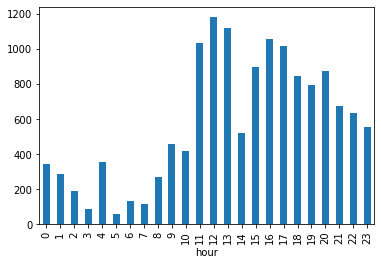

In [104]:
local_host.groupby('hour')['ip'].count().plot(kind='bar')

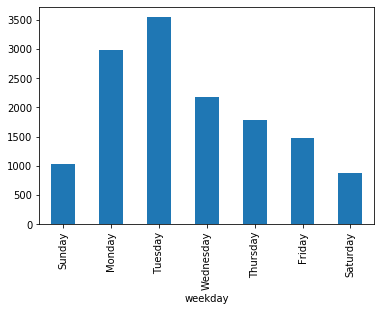

In [106]:
local_host.groupby('weekday')['ip'].count().plot(kind='bar')